# Load dataset

In [29]:
import pandas as pd

# Load dataset

df = pd.read_csv("../data/master.dataset.final.v2.csv")

df = df.dropna(axis=1, how='all')
df = df.dropna(axis=0, how='all')

df




,Species,th.len.m,th.len.m_se,th.wid.m,th.wid.m_se,th.hei.m,th.hei.m_se,th.vol.m,th.vol.m_se,wing.area.m,...,std.aging.rate.m,life.expectancy.f,life.expectancy.m,net.repro.output,early.repro.output,std.sex.siz.diff,std.aging.rate.bias,life.expectancy.bias,anisogamy,OSR
0,C_procnemis,0.985,0.007,0.683,0.005,0.908,0.009,0.612,0.003,1.360,...,4.39,86.947,122.764,166.0,44.0,-0.002,0.612,-0.498,0.000,-0.498
1,D_acutilabella,1.008,0.006,0.773,0.007,0.955,0.015,0.743,0.005,1.432,...,1.71,9.344,11.576,69.0,25.0,0.278,0.052,-0.309,0.000,2.736
2,D_affinis,0.865,0.007,0.628,0.008,0.850,0.016,0.461,0.004,1.229,...,1.98,73.782,135.774,51.0,29.0,0.335,0.559,-0.880,0.004,1.066
3,D_albomicans,1.250,0.042,0.808,0.009,1.048,0.013,1.057,0.013,1.902,...,4.22,55.969,21.319,343.0,122.0,0.245,-0.294,1.393,0.001,4.032
4,D_aldrichi,1.023,0.013,0.760,0.009,0.975,0.011,0.758,0.005,1.777,...,4.34,88.499,100.969,261.0,122.0,0.274,0.223,-0.190,0.001,0.503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Z_ghesquierei,1.160,0.013,0.750,0.004,1.055,0.008,0.918,0.004,1.803,...,1.41,307.698,286.228,252.0,63.0,0.211,-0.104,0.104,0.000,3.149
145,Z_indianus,1.190,0.005,0.808,0.006,1.095,0.006,1.052,0.004,2.029,...,4.00,253.156,334.804,481.0,265.0,-0.064,0.371,-0.403,0.003,-0.403
146,Z_kolodkinae,1.298,0.026,0.968,0.021,1.216,0.026,1.529,0.018,2.120,...,2.89,105.269,80.928,250.0,124.0,0.163,-0.242,0.379,0.001,0.379
147,Z_taronus,1.349,0.007,0.908,0.009,1.260,0.008,1.544,0.007,1.992,...,3.95,310.840,358.722,572.0,267.0,-0.073,0.270,-0.207,0.005,2.432


# Plot phylogenetic tree
This shows the phylogenetic tree to just the species in the dataset. It quickly checks that the tree and the data match, and visually confirm which species are included in the analysis.

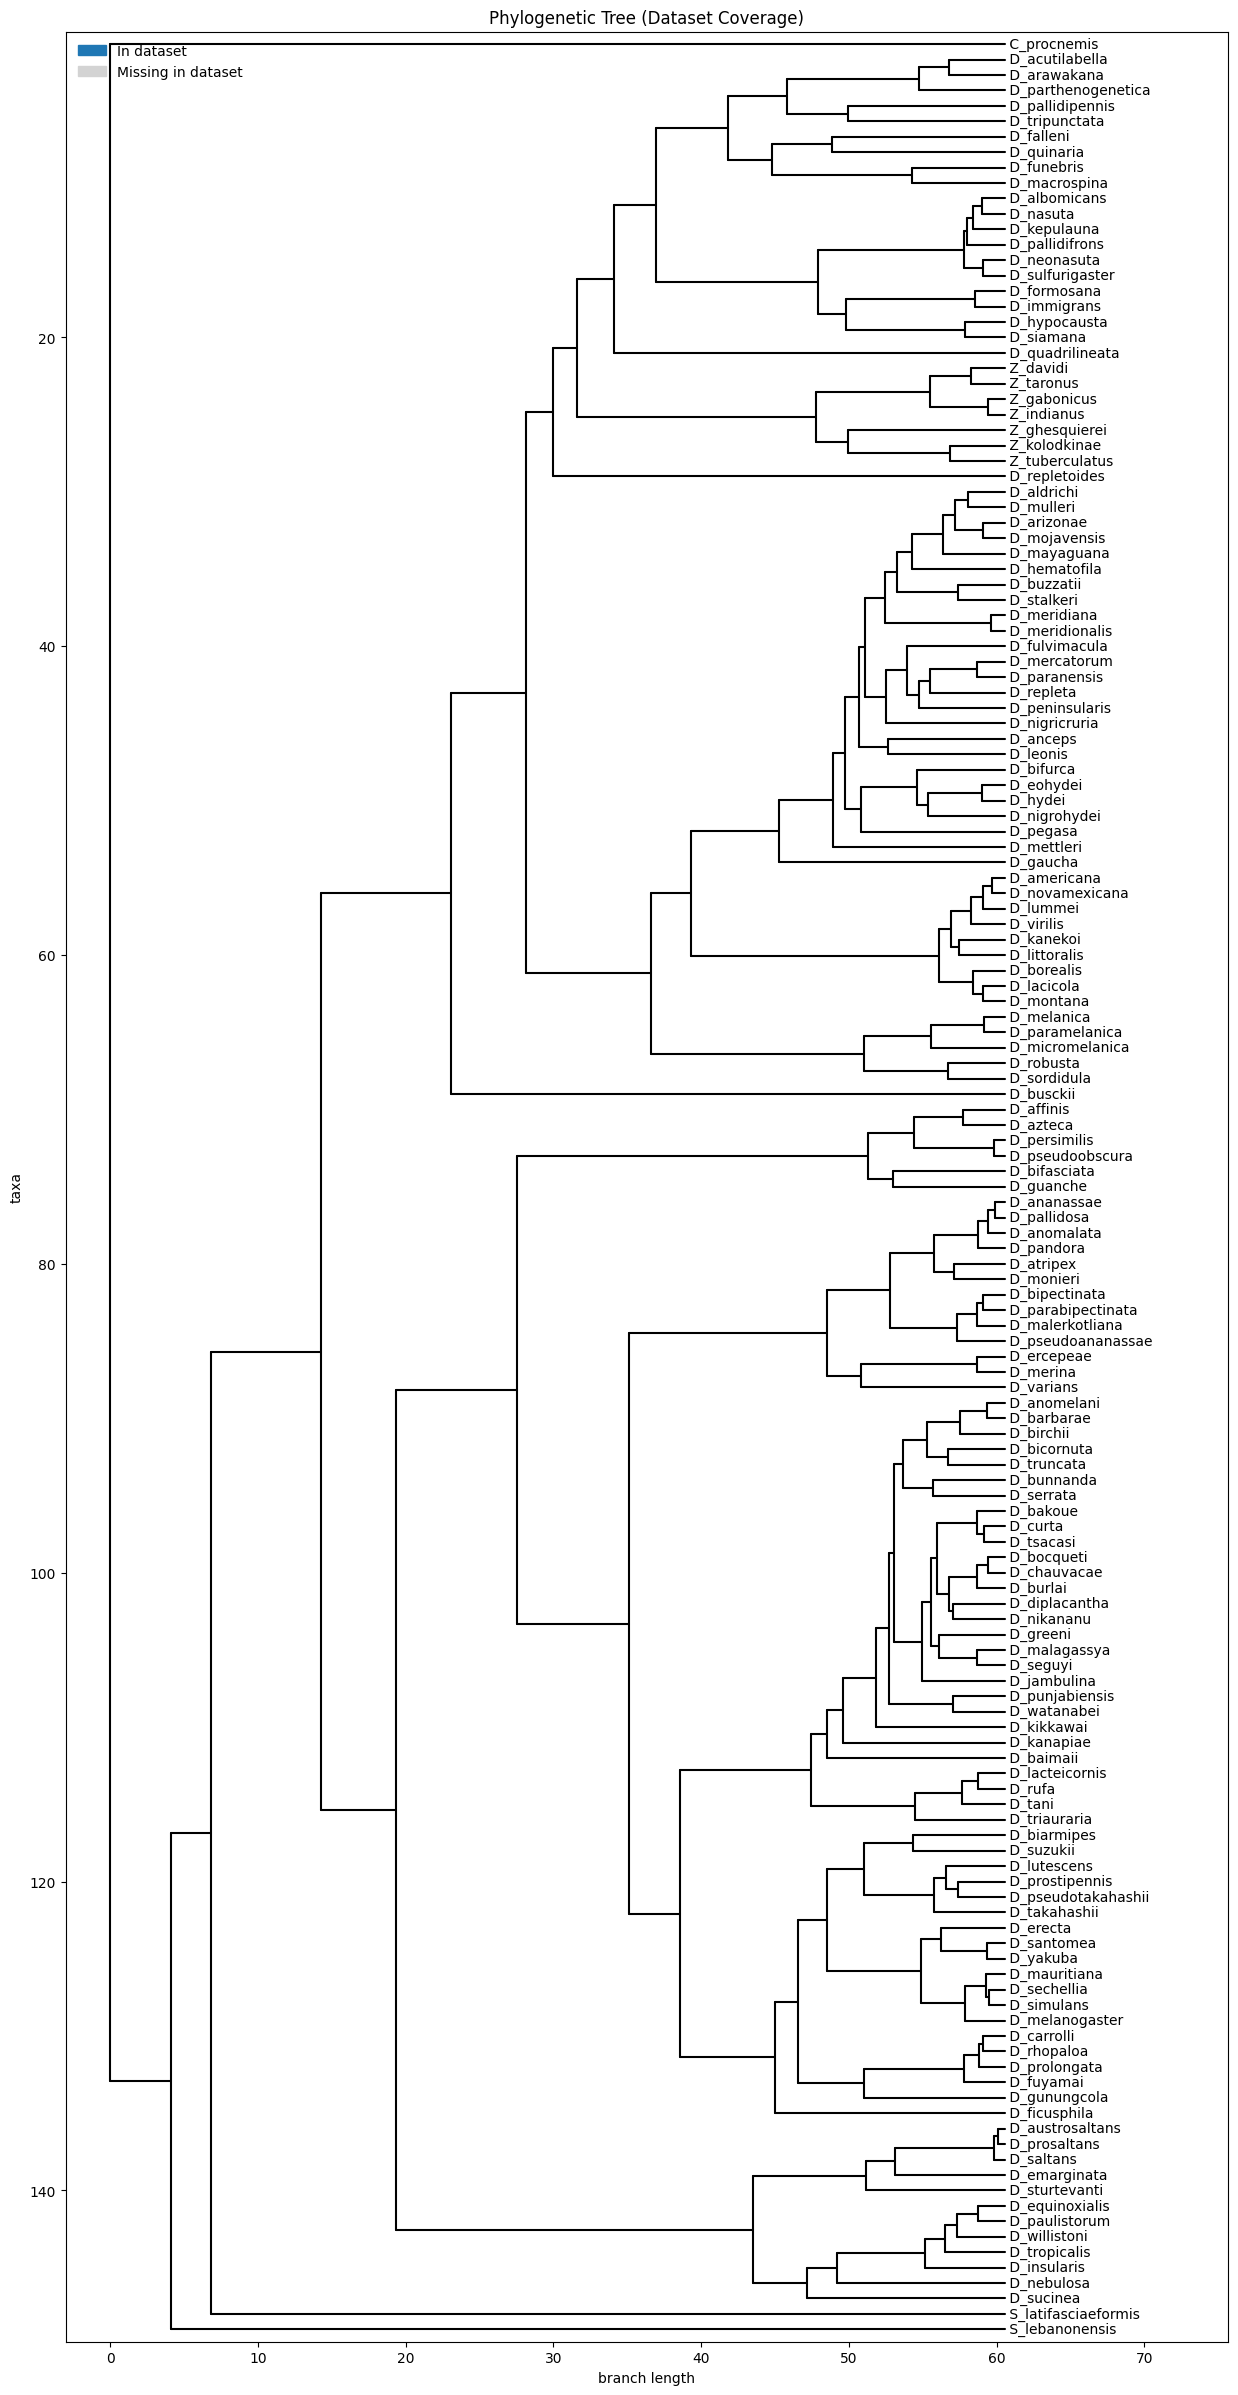

In [30]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from Bio import Phylo


dataset_species = df["Species"].dropna().unique().tolist()
tree = Phylo.read("../data/FlyTree.tre", "newick")



def plot_phylogenetic_tree(tree, dataset_species=None, figsize=(15, 30)):
    fig, ax = plt.subplots(figsize=figsize)
    label_colors, legend_handles = None, None
    
    if dataset_species is not None:
        ds = set(dataset_species)
        label_colors = {
            cl: ("tab:blue" if cl.name in ds else "lightgray")
            for cl in tree.get_terminals()
        }
        legend_handles = [
            Patch(color="tab:blue", label="In dataset"),
            Patch(color="lightgray", label="Missing in dataset"),
        ]

    Phylo.draw(tree, axes=ax, show_confidence=False,
               label_colors=label_colors, do_show=False)
    ax.set_title("Phylogenetic Tree (Dataset Coverage)")
    if legend_handles:
        ax.legend(handles=legend_handles, loc="best", frameon=False)
    return fig, ax

# Use it
fig, ax = plot_phylogenetic_tree(tree, dataset_species)
plt.show()


# UMAP plot colored by phylogenetic distance

This projects all species into a 2D space based on their traits and colors them according to how close or far they are from a chosen reference species in the phylogeny

c:\Users\Prof.Moses Kamya\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Prof.Moses Kamya\AppData\Local\Temp\ipykernel_23156\357841338.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")       # or "cividis", "plasma", "magma", "turbo"


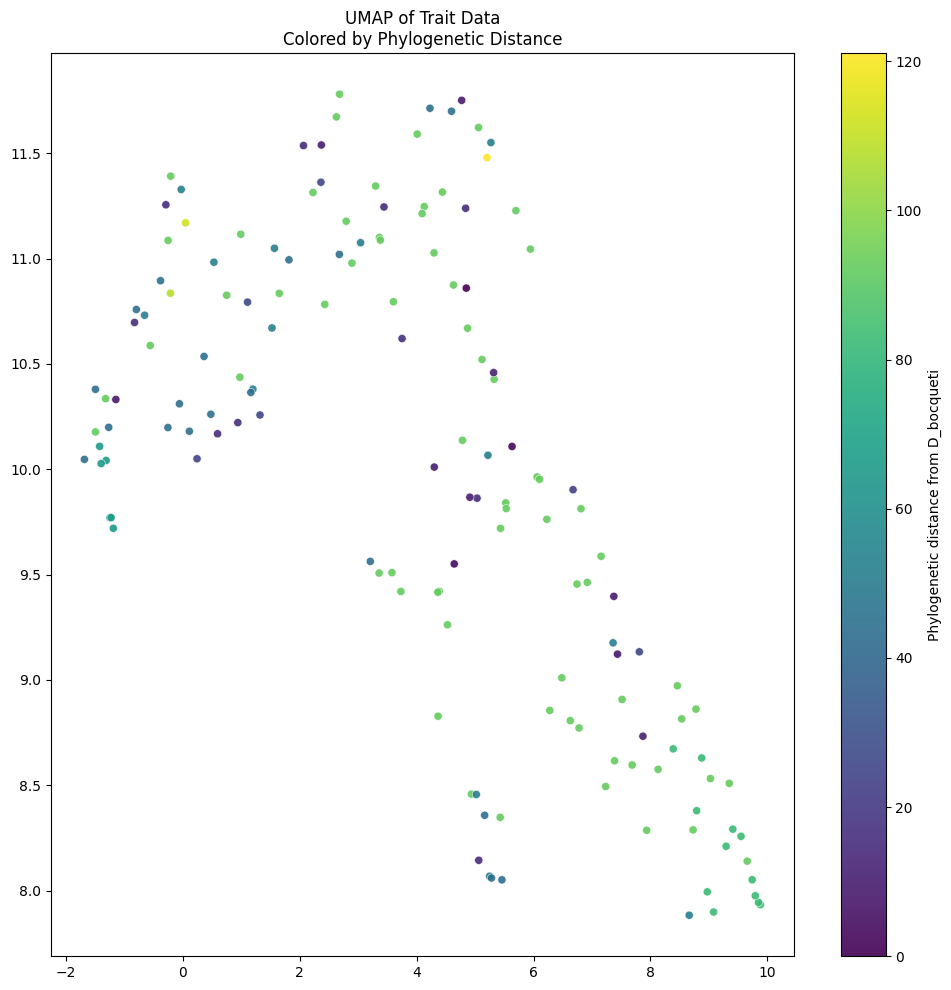

In [34]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm
import numpy as np
from matplotlib import cm, colors as mcolors

species = [t.name for t in tree.get_terminals()]
dist_matrix = np.zeros((len(species), len(species)))

for i, sp1 in enumerate(species):
    for j, sp2 in enumerate(species):
        if i != j:
            dist_matrix[i, j] = tree.distance(sp1, sp2)

df_aligned = df.set_index("Species").loc[species]
X = df_aligned.select_dtypes(include=[np.number]).fillna(df_aligned.mean())
for i, sp1 in enumerate(species):
    for j, sp2 in enumerate(species):
        if i != j:
            dist_matrix[i, j] = tree.distance(sp1, sp2)

try:
    import umap
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(X)
except ImportError:
    from sklearn.decomposition import PCA
    embedding = PCA(n_components=2).fit_transform(X)
            
# Pick reference species (most central)
cmap = cm.get_cmap("viridis")       # or "cividis", "plasma", "magma", "turbo"
norm = mcolors.Normalize(vmin=d.min(), vmax=d.max())

fig, ax = plt.subplots(figsize=(10, 10))
sc = ax.scatter(
    embedding[:, 0], embedding[:, 1],
    c=d, cmap=cmap, norm=norm, s=35, edgecolor="white", linewidth=0.4, alpha=0.9
)
cb = plt.colorbar(sc, ax=ax)
cb.set_label(f"Phylogenetic distance from {ref_species}")
ax.set_title("UMAP of Trait Data\nColored by Phylogenetic Distance")
plt.tight_layout()
plt.show()


# Trait summary table (mean, sd, missing etc)

This part creates a summary of each trait in the dataset. It tells the mean, the standard deviation,  coefficient of variation, median,interquartile range, and how much data is missing

In [23]:
import numpy as np
import pandas as pd

df_aligned = df.set_index("Species").loc[species]
num = df_aligned.select_dtypes(include=[np.number]).copy()

def iqr(x):
    return np.nanpercentile(x, 75) - np.nanpercentile(x, 25)

summary = pd.DataFrame({
    "n": num.count(),
    "missing": num.isna().sum(),
    "missing_%": num.isna().mean()*100,
    "mean": num.mean(),
    "std": num.std(ddof=1),
    "cv": (num.std(ddof=1) / num.mean()).replace([np.inf, -np.inf], np.nan),
    "median": num.median(),
    "iqr": num.apply(iqr, axis=0),
    "min": num.min(),
    "max": num.max(),
})
summary = summary.sort_values("std", ascending=False)
summary.head(25)


c:\Users\Prof.Moses Kamya\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


,n,missing,missing_%,mean,std,cv,median,iqr,min,max
sperm.per.cop,148,1,0.671141,1424.825291,3438.010422,2.412935,745.9000,661.9500,43.400,25000.000
sp.eject.time,127,22,14.765101,369.401717,189.170704,0.512100,335.0000,399.0000,47.308,600.000
net.repro.output,148,1,0.671141,224.743243,176.513248,0.785400,171.5000,212.5000,32.000,967.000
sperm.per.cop_se,143,6,4.026846,72.424524,158.113061,2.183143,43.6960,39.0890,0.000,1443.195
TRI.m.unweighted,149,0,0.000000,225.000000,85.852010,0.381564,219.0000,125.0000,27.000,402.000
early.repro.output,148,1,0.671141,71.493243,67.527419,0.944529,50.0000,69.5000,0.000,295.000
life.expectancy.m,148,1,0.671141,68.949108,60.616136,0.879143,52.6110,54.7095,4.572,403.323
life.expectancy.f,148,1,0.671141,72.579250,51.360105,0.707642,59.3015,56.3445,7.264,310.840
rank.res.ag.area,149,0,0.000000,75.000000,43.156691,0.575423,75.0000,74.0000,1.000,149.000
rank.res.testis.mass,149,0,0.000000,75.000000,43.156691,0.575423,75.0000,74.0000,1.000,149.000


# Z-score matrix

Here is standardizing every trait so they’re all on the same scale (mean of 0 and standard deviation of 1). This makes traits comparable. Then calculate how extreme each species is across traits on average.

In [25]:
# Z-score (mean 0, std 1) per trait
Z = (num - num.mean()) / num.std(ddof=1)
Z = Z.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Species-level dispersion across traits: how "extreme" each species is overall
species_dispersion = Z.abs().mean(axis=1).sort_values(ascending=False)
species_dispersion.head(10)


Species
D_bifurca        1.482719
D_kanekoi        1.201695
Z_taronus        1.121479
D_fulvimacula    1.082017
D_nigrohydei     1.015891
D_hydei          0.972648
D_eohydei        0.949723
D_prolongata     0.915962
D_prosaltans     0.903643
Z_indianus       0.894020
dtype: float64

# Adding error bars on a trait by group

This part compares traits between groups of species. For each group it shows the average value and the standard deviation . The error bar shows how much variation there is inside that group. If the error bars are short, the trait is very consistent across species in the group. If the error bars are long, the trait varies a lot within the group

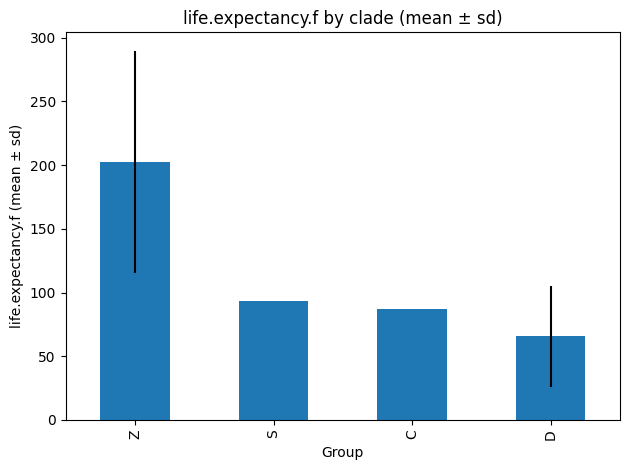

In [28]:
import matplotlib.pyplot as plt

ax = stats_by_group[['mean']].plot(kind='bar', yerr=stats_by_group['std'], legend=False)
ax.set_ylabel(f"{trait} (mean ± sd)")
ax.set_title(f"{trait} by clade (mean ± sd)")
plt.tight_layout(); plt.show()


# Local variability in UMAP space

Here is looking at how consistent a trait is among species that are close together in the UMAP plot. For each species, it checks its 15 nearest neighbors in UMAP space and calculate the standard deviation of their values. If the local SD is low, the neighborhood is consistent (a strong syndrome). If it’s high, the neighborhood is mixed (possible interaction or ecological effect).

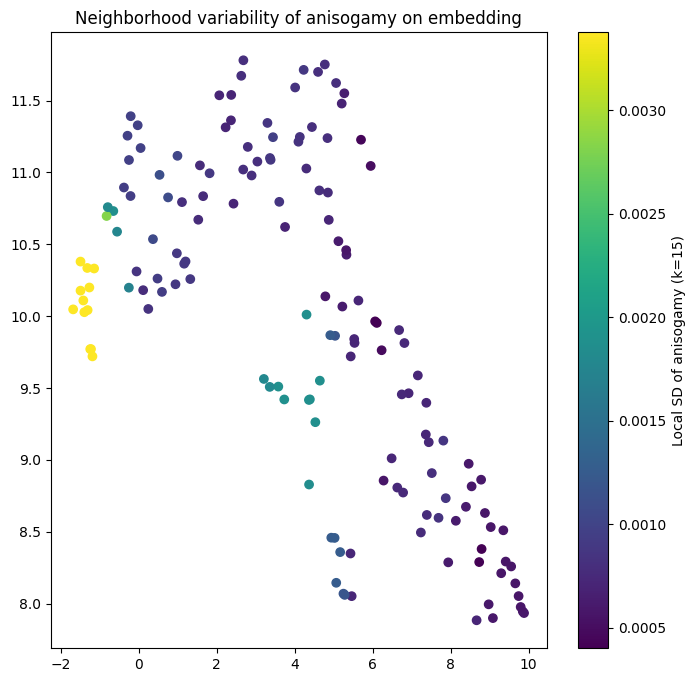

In [29]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


t = "anisogamy"
vals = num[t].values

nbrs = NearestNeighbors(n_neighbors=15).fit(embedding)
dist, idx = nbrs.kneighbors(embedding)

local_sd = np.array([np.nanstd(vals[i_neighbors]) for i_neighbors in idx])

# Plot on embedding
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
sc = ax.scatter(embedding[:,0], embedding[:,1], c=local_sd)
plt.colorbar(sc, label=f"Local SD of {t} (k=15)")
ax.set_title(f"Neighborhood variability of {t} on embedding")
plt.show()
